In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unet-files/model.py
/kaggle/input/unet-files/training_utils.py
/kaggle/input/unet-files/utils.py
/kaggle/input/unet-files/dataset.py


In [3]:
!pip install torchsummary

In [4]:
# Standard Library Imports
import os
import sys

# Third-Party Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchsummary import summary

# from google.colab import drive
# drive.mount('/content/drive')



In [6]:
cd /kaggle/input

/kaggle/input


In [14]:
import sys
sys.path.append( "/kaggle/input/unet-files" )

In [16]:
from utils import tensor_trimap, args_to_dict, display_loss_and_accuracies, display_output
from dataset import OxfordIIITPetsAugmented
from model import UNet
from training_utils import train, test, dice_loss

In [17]:
transform_dict = args_to_dict(
    pre_transform = transforms.ToTensor(),
    pre_target_transform = transforms.ToTensor(),
    common_transform = transforms.Compose([
        transforms.Resize((128,128), interpolation=transforms.InterpolationMode.NEAREST)
    ]),

    post_transform = transforms.Compose([transforms.ColorJitter(contrast=0.3)]),

    post_target_transform = transforms.Compose([transforms.Lambda(tensor_trimap)]),
)

In [19]:
train_dataset = OxfordIIITPetsAugmented(
    root = '/kaggle/working/OxfordIIITPets',
    split = 'trainval',
    target_types = 'segmentation',
    download = True,
    **transform_dict,
)

100%|██████████| 791918971/791918971 [00:27<00:00, 28439712.53it/s]


Extracting /kaggle/working/OxfordIIITPets/oxford-iiit-pet/images.tar.gz to /kaggle/working/OxfordIIITPets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 12128231.37it/s]


Extracting /kaggle/working/OxfordIIITPets/oxford-iiit-pet/annotations.tar.gz to /kaggle/working/OxfordIIITPets/oxford-iiit-pet


In [21]:
test_dataset = OxfordIIITPetsAugmented(
    root = '/kaggle/working/OxfordIIITPets',
    split = 'test',
    target_types = 'segmentation',
    download = True,
    **transform_dict,
)

In [22]:
seed = 8
batch_size = 16
torch.batch_norm_stats

cuda= torch.cuda.is_available()
device = torch.device('cuda' if cuda else 'cpu')

torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train_dataset, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test_dataset, **dataloader_args)

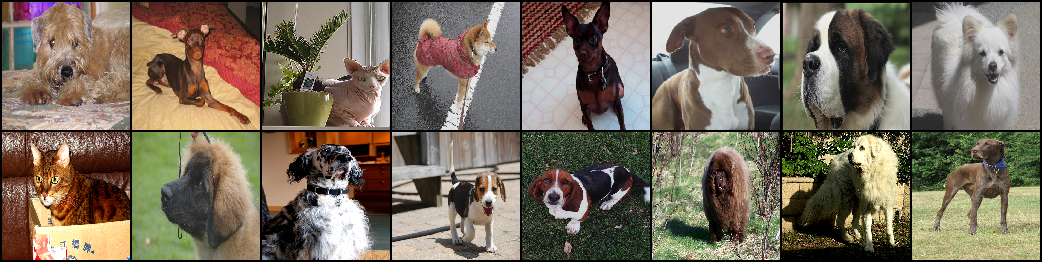

In [23]:
t2img = transforms.ToPILImage()
train_pets_inputs, train_pets_targets = next(iter(train_loader))
pets_input_grid = torchvision.utils.make_grid(train_pets_inputs, nrow=8)
pets_target_grid = torchvision.utils.make_grid(train_pets_targets/2.0, nrow=8)

t2img(pets_input_grid)


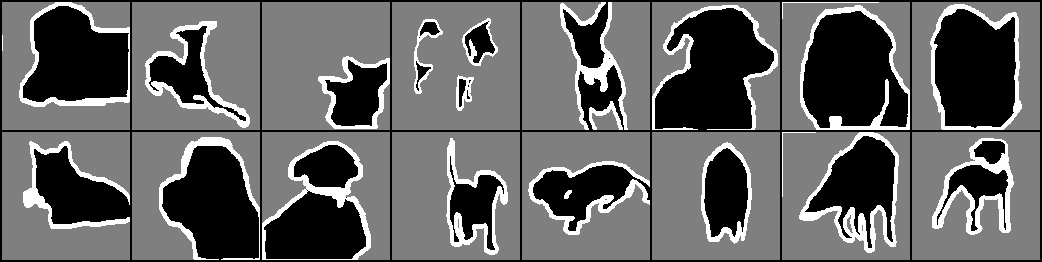

In [24]:
t2img(pets_target_grid)


In [25]:
epochs = 15
lr = 0.001
momentum = 0.9
weight_decay = 1e-4

In [38]:
def train_model(model, loss):
    """
    Function to train the model
    """
    # Data to plot accuracy and loss graphs
    train_losses = []
    test_losses = []

    # Optimization algorithm to update the weights
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Scheduler to change the learning rate after specific number of epochs
    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.7)
    scheduler = None

    # CE OR Dice Loss
    criterion = loss

    # For each epoch
    for epoch in range(1, epochs+1):
        print(" ")
        print(f'Epoch {epoch}')

        # Train the model on training dataset and append the training loss and accuracy
        train_loss = train(model, device, train_loader, optimizer, criterion, scheduler)
        train_losses.append(train_loss / len(train_loader))

        # Test the model's performance on test dataset and append the training loss and accuracy
        test_loss = test(model, device, test_loader, criterion)
        test_losses.append(test_loss)

    display_loss_and_accuracies(train_losses, test_losses)

## Max pooling + transpose + BCE

 
Epoch 1


Train: Loss=0.6280 Batch_id=229: 100%|██████████| 230/230 [00:37<00:00,  6.13it/s]


Test set: Average loss: 0.5997
 
Epoch 2


Train: Loss=0.5086 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  6.03it/s]


Test set: Average loss: 0.4641
 
Epoch 3


Train: Loss=0.3219 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.6326
 
Epoch 4


Train: Loss=0.4110 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.5207
 
Epoch 5


Train: Loss=0.4358 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  6.00it/s]


Test set: Average loss: 0.3829
 
Epoch 6


Train: Loss=0.3476 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.3503
 
Epoch 7


Train: Loss=0.3395 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.3765
 
Epoch 8


Train: Loss=0.2950 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.3674
 
Epoch 9


Train: Loss=0.3257 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.3291
 
Epoch 10


Train: Loss=0.3336 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.3147
 
Epoch 11


Train: Loss=0.2789 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.3319
 
Epoch 12


Train: Loss=0.2509 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.3473
 
Epoch 13


Train: Loss=0.3156 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.3079
 
Epoch 14


Train: Loss=0.2364 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2974
 
Epoch 15


Train: Loss=0.2292 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.99it/s]


Test set: Average loss: 0.3311


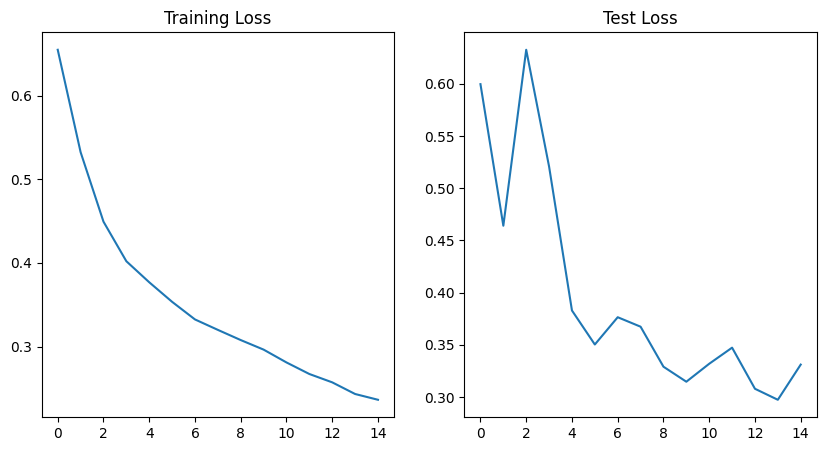

In [39]:
model = UNet(in_channels=3, out_channels=3).to(device)
# summary(model, (3, 128, 128))

loss = nn.CrossEntropyLoss()
train_model(model, loss)

## maxpooling + transpose + dice loss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
         MaxPool2d-7           [-1, 64, 64, 64]               0
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.3930 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.96it/s]


Test set: Average loss: 0.3761
 
Epoch 2


Train: Loss=0.3551 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2973
 
Epoch 3


Train: Loss=0.2795 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.3068
 
Epoch 4


Train: Loss=0.3254 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.3524
 
Epoch 5


Train: Loss=0.2834 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.98it/s]


Test set: Average loss: 0.2691
 
Epoch 6


Train: Loss=0.3176 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.96it/s]


Test set: Average loss: 0.3428
 
Epoch 7


Train: Loss=0.2229 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2595
 
Epoch 8


Train: Loss=0.2793 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.94it/s]


Test set: Average loss: 0.2522
 
Epoch 9


Train: Loss=0.1941 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.95it/s]


Test set: Average loss: 0.2456
 
Epoch 10


Train: Loss=0.2192 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2307
 
Epoch 11


Train: Loss=0.2411 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2486
 
Epoch 12


Train: Loss=0.2147 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2181
 
Epoch 13


Train: Loss=0.2466 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2601
 
Epoch 14


Train: Loss=0.2466 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2223
 
Epoch 15


Train: Loss=0.2197 Batch_id=229: 100%|██████████| 230/230 [00:38<00:00,  5.97it/s]


Test set: Average loss: 0.2239


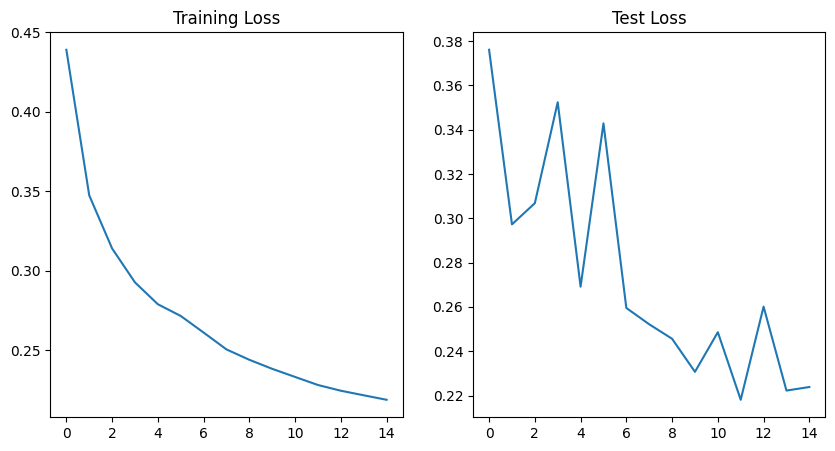

In [40]:
model = UNet(in_channels=3, out_channels=3).to(device)
summary(model, (3, 128, 128))

loss = dice_loss
train_model(model, loss)

## strided conv + transpose + BCE

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.5774 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.79it/s]


Test set: Average loss: 0.6220
 
Epoch 2


Train: Loss=0.5568 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.6224
 
Epoch 3


Train: Loss=0.4813 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.4665
 
Epoch 4


Train: Loss=0.5141 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.4361
 
Epoch 5


Train: Loss=0.3322 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.4168
 
Epoch 6


Train: Loss=0.3083 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.4401
 
Epoch 7


Train: Loss=0.4506 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.3754
 
Epoch 8


Train: Loss=0.3704 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.77it/s]


Test set: Average loss: 0.3573
 
Epoch 9


Train: Loss=0.4382 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.75it/s]


Test set: Average loss: 0.3617
 
Epoch 10


Train: Loss=0.2986 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.3849
 
Epoch 11


Train: Loss=0.2944 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.3411
 
Epoch 12


Train: Loss=0.2921 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.75it/s]


Test set: Average loss: 0.3294
 
Epoch 13


Train: Loss=0.2854 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.77it/s]


Test set: Average loss: 0.3834
 
Epoch 14


Train: Loss=0.2548 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.75it/s]


Test set: Average loss: 0.3306
 
Epoch 15


Train: Loss=0.3324 Batch_id=229: 100%|██████████| 230/230 [00:39<00:00,  5.78it/s]


Test set: Average loss: 0.3322


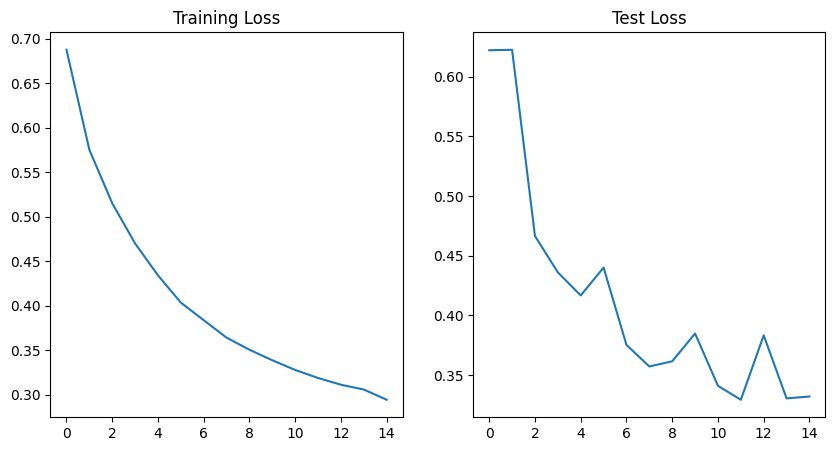

In [41]:
model = UNet(in_channels=3, out_channels=3, max_pool = False).to(device)
summary(model, (3, 128, 128))

loss = nn.CrossEntropyLoss()
train_model(model, loss)

## strided conv + upsampling + dice losss

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
            Conv2d-4         [-1, 64, 128, 128]          36,928
       BatchNorm2d-5         [-1, 64, 128, 128]             128
              ReLU-6         [-1, 64, 128, 128]               0
            Conv2d-7           [-1, 64, 64, 64]          16,448
  ContractingBlock-8  [[-1, 64, 64, 64], [-1, 64, 128, 128]]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
           Conv2d-12          [-1, 128, 64, 64]         147,584
      BatchNorm2d-13          [-1, 128, 64, 64]             256
             ReLU-14      

Train: Loss=0.4332 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.4103
 
Epoch 2


Train: Loss=0.4039 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.3587
 
Epoch 3


Train: Loss=0.3103 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.3154
 
Epoch 4


Train: Loss=0.3744 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.36it/s]


Test set: Average loss: 0.3521
 
Epoch 5


Train: Loss=0.3033 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.3546
 
Epoch 6


Train: Loss=0.3116 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.3162
 
Epoch 7


Train: Loss=0.2122 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.2806
 
Epoch 8


Train: Loss=0.3220 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.37it/s]


Test set: Average loss: 0.2689
 
Epoch 9


Train: Loss=0.2275 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.37it/s]


Test set: Average loss: 0.2517
 
Epoch 10


Train: Loss=0.2370 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2487
 
Epoch 11


Train: Loss=0.2545 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2451
 
Epoch 12


Train: Loss=0.2833 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.38it/s]


Test set: Average loss: 0.2526
 
Epoch 13


Train: Loss=0.2349 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2366
 
Epoch 14


Train: Loss=0.2583 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.37it/s]


Test set: Average loss: 0.2295
 
Epoch 15


Train: Loss=0.2562 Batch_id=229: 100%|██████████| 230/230 [00:42<00:00,  5.39it/s]


Test set: Average loss: 0.2742


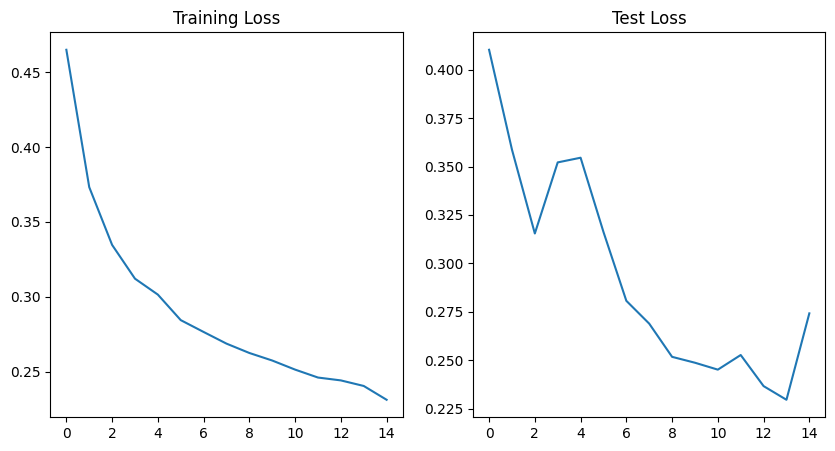

In [42]:
model = UNet(in_channels=3, out_channels=3, max_pool = False, transpose= False).to(device)
summary(model, (3, 128, 128))

loss = dice_loss
train_model(model, loss)

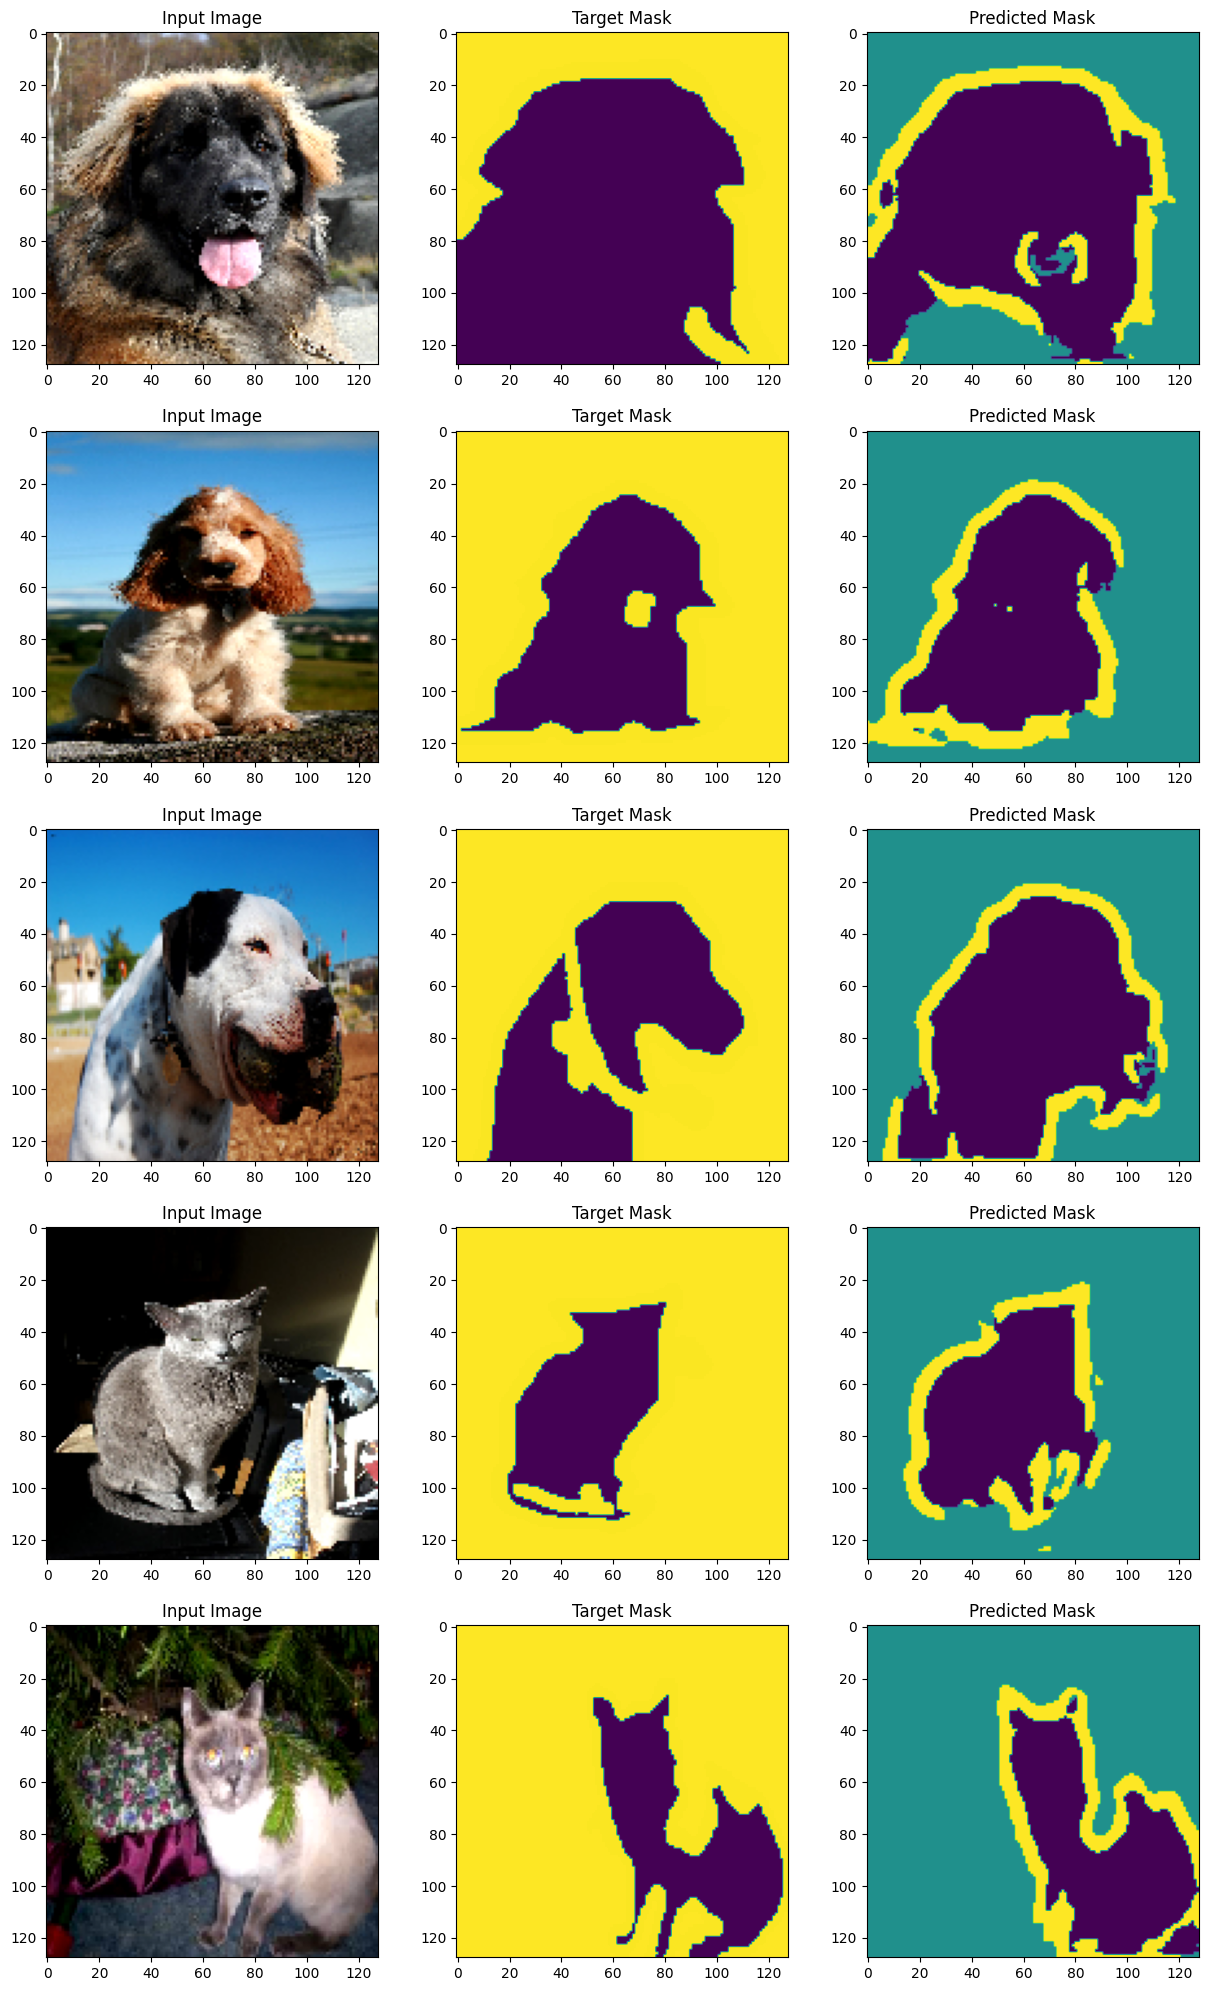

In [45]:
display_output(model, test_loader)

In [46]:
torch.save(model.state_dict(), 'model.pth')

RuntimeError: File model.pth cannot be opened.